In [36]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from fredapi import Fred
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

DATA_DIR = 'data'
os.makedirs(DATA_DIR, exist_ok=True)

print(f"✅ Data directory setup: {DATA_DIR}")

✅ Data directory setup: data


In [2]:
def collect_market_data(start_date='1996-01-01', end_date='2025-05-02'):
    """"
Collect S&P 500 and VIX data from Yahoo Finance
    """
    print("Collecting S&P 500 and VIX market data...")
    # Download S&P 500 data
    sp500 = yf.download('^GSPC', start=start_date, end=end_date, progress=False)

    # Handle multi-level columns if they exist
    if isinstance(sp500.columns, pd.MultiIndex):
        sp500.columns = sp500.columns.get_level_values(0)

    # Select S&P 500 columns
    sp500 = sp500[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
    sp500.columns = [f'SP500_{col}' for col in sp500.columns]

    # Download VIX data
    vix = yf.download('^VIX', start=start_date, end=end_date, progress=False)

    # Handle multi-level columns if they exist
    if isinstance(vix.columns, pd.MultiIndex):
        vix.columns = vix.columns.get_level_values(0)

    # Select VIX close
    vix = vix[['Close']].copy()
    vix.columns = ['VIX']

    # Combine SP500 and VIX
    market_data = pd.concat([sp500, vix], axis=1)

    print(f"Market data collected: {len(market_data)} observations")
    return market_data

In [37]:
fred_api_key = "your fred api key here"

In [ ]:
def collect_macro_data(start_date='1996-01-01', end_date='2025-05-02'):
    """
    Collect macroeconomic data from FRED and Yahoo Finance as specified in instructions
    """
    print("Collecting macroeconomic data...")
    
    try:
        fred = Fred(api_key=fred_api_key)
        print("Fetching Treasury yields...")
        # 10-year Treasury yield
        try:
            treasury_10y = fred.get_series('DGS10', start=start_date, end=end_date)
            treasury_10y = pd.DataFrame(treasury_10y, columns=['Treasury_10Y'])
            print(f"  10Y Treasury: {len(treasury_10y)} observations")
        except Exception as e:
            print(f"  Warning: Failed to fetch 10Y Treasury data: {e}")
            treasury_10y = pd.DataFrame(columns=['Treasury_10Y'])
        
        # 2-year Treasury yield
        try:
            treasury_2y = fred.get_series('DGS2', start=start_date, end=end_date)
            treasury_2y = pd.DataFrame(treasury_2y, columns=['Treasury_2Y'])
            print(f"  2Y Treasury: {len(treasury_2y)} observations")
        except Exception as e:
            print(f"  Warning: Failed to fetch 2Y Treasury data: {e}")
            treasury_2y = pd.DataFrame(columns=['Treasury_2Y'])

        try:
            wti = fred.get_series('DCOILWTICO', start=start_date, end=end_date)  # Using better FRED series
            wti = pd.DataFrame(wti, columns=['WTI_Crude'])
            print(f"  WTI Crude (FRED): {len(wti)} observations")
        except Exception as e:
            print(f"  Warning: Failed to fetch WTI Crude data from FRED: {e}")
            wti = pd.DataFrame(columns=['WTI_Crude'])
        
        # Gold price
        try:
            gold = yf.download('GC=F', start=start_date, end=end_date, progress=False)
            if isinstance(gold.columns, pd.MultiIndex):
                gold.columns = gold.columns.get_level_values(0)
                gold = gold[['Close']].copy()
                gold.columns = ['Gold']
            print(f"  Gold: {len(gold)} observations")
        except Exception as e:
            print(f"  Warning: Failed to fetch Gold data: {e}")
            gold = pd.DataFrame(columns=['Gold'])
            print("Fetching Yahoo Finance data...")
        # Yahoo Finance data for DXY, WTI crude, Gold
        # Dollar Index (DXY)
        try:
            dxy = yf.download('DX-Y.NYB', start=start_date, end=end_date, progress=False)
            if isinstance(dxy.columns, pd.MultiIndex):
                dxy.columns = dxy.columns.get_level_values(0)
            dxy = dxy[['Close']].copy()
            dxy.columns = ['DXY']
            print(f"  DXY: {len(dxy)} observations")
        except Exception as e:
            print(f"  Warning: Failed to fetch DXY data: {e}")
            dxy = pd.DataFrame(columns=['DXY'])
        
        # Combine all macro data
        macro_data = pd.concat([treasury_10y, treasury_2y, dxy, wti, gold], axis=1)
        
        print(f"Macroeconomic data collected: {len(macro_data)} observations")
        print(f"Columns: {list(macro_data.columns)}")
        return macro_data
        
    except Exception as e:
        print(f"Error in collect_macro_data: {e}")
        print("Returning empty DataFrame to prevent crash")
        return pd.DataFrame()

# Note: Function defined but not called automatically to prevent crashes
print("✅ collect_macro_data function defined with error handling")

✅ collect_macro_data function defined with error handling


In [4]:
def align_frequencies(sp500_vix_data, macro_data):
    """
    Align different frequency data using forward-fill method
    """
    print("Aligning data frequencies...")
    
    # Get all trading days from S&P 500 data
    all_dates = sp500_vix_data.index
    
    # Reindex macro data to match trading days and forward fill
    macro_aligned = macro_data.reindex(all_dates, method='ffill')
    
    # Combine all data
    combined_data = pd.concat([sp500_vix_data, macro_aligned], axis=1)
    
    print(f"Aligned data: {len(combined_data)} observations")
    return combined_data

In [5]:
macro_data = collect_macro_data()
market_data = collect_market_data()

Fetching Treasury yields...
  10Y Treasury: 16547 observations
  2Y Treasury: 12787 observations
  WTI Crude (FRED): 10283 observations
YF.download() has changed argument auto_adjust default to True
  Gold: 6189 observations
  DXY: 7442 observations
Macroeconomic data collected: 16547 observations
Columns: ['Treasury_10Y', 'Treasury_2Y', 'DXY', 'WTI_Crude', 'Gold']
Market data collected: 7382 observations


In [6]:
combined_data = align_frequencies(
    market_data, macro_data
)

Aligning data frequencies...
Aligned data: 7382 observations


## Apply when using API ##

In [ ]:
combined_data.to_csv(os.path.join(DATA_DIR, 'combined_data.csv'), index=True)
macro_data.to_csv(os.path.join(DATA_DIR, 'macro_data.csv'), index=True)
market_data.to_csv(os.path.join(DATA_DIR, 'market_data.csv'), index=True)

## Import of data without API ##

In [39]:
macro_data = pd.read_csv(os.path.join(DATA_DIR, 'macro_data.csv'), index_col=0, parse_dates=True)
market_data = pd.read_csv(os.path.join(DATA_DIR, 'market_data.csv'), index_col=0, parse_dates=True)
combined_data = pd.read_csv(os.path.join(DATA_DIR, 'combined_data.csv'), index_col=0, parse_dates=True)
print("Data imported successfully:")
print(f"Macro data shape: {macro_data.shape}")
print(f"Market data shape: {market_data.shape}")

Data imported successfully:
Macro data shape: (16547, 5)
Market data shape: (7382, 6)


In [8]:
combined_data.head()

,SP500_Open,SP500_High,SP500_Low,SP500_Close,SP500_Volume,VIX,Treasury_10Y,Treasury_2Y,DXY,WTI_Crude,Gold
Date,,,,,,,,,,,
1996-01-02,615.929993,620.739990,613.169983,620.729980,364180000,12.19,5.60,5.18,84.690002,19.83,NaN
1996-01-03,620.729980,623.250000,619.559998,621.320007,468950000,12.10,5.58,5.17,85.110001,19.90,NaN
1996-01-04,621.320007,624.489990,613.960022,617.700012,512580000,13.78,5.65,5.17,85.220001,19.96,NaN
1996-01-05,617.700012,617.700012,612.020020,616.710022,437110000,13.58,5.69,5.20,85.059998,20.26,NaN
1996-01-08,616.710022,618.460022,616.489990,618.460022,130360000,13.11,5.68,5.20,85.040001,20.50,NaN


In [ ]:

def create_bull_bear_labels_LT(
    data: pd.DataFrame,
    price_col: str = "SP500_Close",
    up_threshold: float = 0.15,
    down_threshold: float = 0.10,
    align_to: str = "W-FRI",
    verbose: bool = True,
    return_weekly: bool = False,
) -> pd.DataFrame:
    """
    Lunde & Timmermann (2004) bull/bear regime labelling.

    Parameters
    ----------
    data : DataFrame with a DatetimeIndex and a price column.
    price_col : name of the (adjusted) close column.
    up_threshold / down_threshold : 0.20 = 20 % rebound / draw-down.
    align_to : pandas offset alias – Friday by default.
    verbose : print a quick regime summary.

    Returns
    -------
    copy of `data` with an int column `Regime_Label`
        (1 = bull, 0 = bear);
    the weekly labels are also attached as
        df.attrs['weekly_labels']  (Series, freq = `align_to`)
    """

    if price_col not in data.columns:
        raise KeyError(f"{price_col} not found in DataFrame")

    df = data.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
      df.set_index(pd.to_datetime(df.index), inplace=True)

    P = df[price_col].values
    dates = df.index
    n = len(P)
    label = np.empty(n, dtype=int)

    # ------------------------------------------------ initial regime (LT)
    p_max = p_min = P[0]
    up_hits = down_hits = 0
    i = 1
    while i < n and up_hits < 3 and down_hits < 3:
        if P[i] >= p_max:
            p_max = P[i]; up_hits += 1
        elif P[i] <= p_min:
            p_min = P[i]; down_hits += 1
        i += 1

    bull = up_hits == 3                  # True → bull, False → bear
    state = "peak" if bull else "trough"
    label[:i] = 1 if bull else 0

    for t in range(i, n):
        price = P[t]

        if state == "peak":                                 
            if price >= p_max:                              
                p_max = price
            elif price <= p_max * (1 - down_threshold):     
                bull = False
                state = "trough"
                p_min = price
        else:                                               
            if price <= p_min:                              
                p_min = price
            elif price >= p_min * (1 + up_threshold):       
                bull = True
                state = "peak"
                p_max = price

        label[t] = 1 if bull else 0

    #add labels & expand to Fridays
    df["Regime_Label"] = label
    weekly_labels = df["Regime_Label"].resample(align_to).last()
    

    # propagate Friday value to every following day until the next Friday
    daily_labels = weekly_labels.reindex(df.index, method="bfill")
    # if the sample starts mid-week fill the head as well
    daily_labels.fillna(method="bfill", inplace=True)

    df["Regime_Label"] = daily_labels.astype(int)
    df.attrs["last_switch"] = weekly_labels.index[weekly_labels.diff().abs() == 1].max()

    if verbose:
        bull_w = int((weekly_labels == 1).sum())
        bear_w = int((weekly_labels == 0).sum())
        switches = int(weekly_labels.diff().abs().sum())
        print(f"Lunde–Timmermann dating completed "
              f"({df.index.min().date()} → {df.index.max().date()})")
        print(f"  Bull weeks : {bull_w} ({bull_w/len(weekly_labels):.1%})")
        print(f"  Bear weeks : {bear_w} ({bear_w/len(weekly_labels):.1%})")
        print(f"  Regime switches: {switches}")

    return df


In [10]:
def transform_sp500_features(data):    
     #Log-volume
    data['SP500_Log_Volume'] = np.log(data['SP500_Volume'])
    
     #Daily range (derived feature)
    data['SP500_Range'] = (data['SP500_High'] - data['SP500_Low']) / data['SP500_Close']
    
    return data

def _calculate_rsi(price_series, window=14):
    """
    Helper function to calculate RSI
    """
    delta = price_series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def _calculate_wpr(data, window: int = 14):
    high = data["SP500_High"].rolling(window).max()
    low  = data["SP500_Low"].rolling(window).min()
    denom = (high - low).replace(0, np.nan)  # avoid /0
    return 100 * (data["SP500_Close"] - high) / denom

def calculate_technical_indicators(data):
    # Daily log-return
    data['SP500_Log_Returns'] = np.log(data['SP500_Close'] / data['SP500_Close'].shift(1))
    
    # Moving averages: 5day, 10 day
    data['SP500_MA_5'] = data['SP500_Close'].rolling(window=5).mean()
    data['SP500_MA_10'] = data['SP500_Close'].rolling(window=10).mean()
    
    # Rolling averages: 5 day, 10 day (same as moving averages)
    data['SP500_SMA_5'] = data['SP500_Close'].rolling(window=5).mean()
    data['SP500_SMA_10'] = data['SP500_Close'].rolling(window=10).mean()
    
    # RSI
    data['SP500_RSI'] = _calculate_rsi(data['SP500_Close'], window=14)
    
    # MACD
    exp1 = data['SP500_Close'].ewm(span=12).mean()
    exp2 = data['SP500_Close'].ewm(span=26).mean()
    data['SP500_MACD'] = exp1 - exp2
    data['SP500_MACD_Signal'] = data['SP500_MACD'].ewm(span=9).mean()
    
    # ATR
    data['SP500_High_Low'] = data['SP500_High'] - data['SP500_Low']
    data['SP500_High_Close'] = abs(data['SP500_High'] - data['SP500_Close'].shift(1))
    data['SP500_Low_Close'] = abs(data['SP500_Low'] - data['SP500_Close'].shift(1))
    data['SP500_TR'] = data[['SP500_High_Low', 'SP500_High_Close', 'SP500_Low_Close']].max(axis=1)
    data['SP500_ATR'] = data['SP500_TR'].rolling(window=14).mean()
    
    # MTM1/MTM3: difference between current price and price 1-3 months ago
    data['SP500_MTM1'] = data['SP500_Close'] - data['SP500_Close'].shift(21)  # ~1 month
    data['SP500_MTM3'] = data['SP500_Close'] - data['SP500_Close'].shift(63)  # ~3 months
    
    # WPR (Williams %R)
    data['SP500_WPR'] = _calculate_wpr(data, window=14)
    
    # SRA 5 day, 10 day (Simple Rate of Change)
    data['SP500_SRA_5'] = (data['SP500_Close'] / data['SP500_Close'].shift(5) - 1) * 100
    data['SP500_SRA_10'] = (data['SP500_Close'] / data['SP500_Close'].shift(10) - 1) * 100
    
    # Clean up intermediate columns
    cols_to_drop = ['SP500_High_Low', 'SP500_High_Close', 'SP500_Low_Close', 'SP500_TR']
    data = data.drop(columns=[col for col in cols_to_drop if col in data.columns])
    
    return data

In [11]:
transformed_raw_data = transform_sp500_features(combined_data)
full_data = calculate_technical_indicators(transformed_raw_data)

/opt/anaconda3/envs/Market_class/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
full_data.dropna(inplace=True)  

In [ ]:
# Data Quality Check 
print("\nData Quality Check Before Splitting:")
print("=" * 60)

# Check for infinity and NaN values in the full dataset
inf_count = full_data.isin([np.inf, -np.inf]).sum().sum()
nan_count = full_data.isna().sum().sum()

print(f"Total infinity values: {inf_count}")
print(f"Total NaN values: {nan_count}")

if inf_count > 0:
    # Find which features have infinity
    inf_features = full_data.columns[full_data.isin([np.inf, -np.inf]).any()]
    print(f"Features with infinity: {list(inf_features)}")
    
    # Show some infinity values for the first 3 problematic features
    for feat_name in inf_features[:3]:
        inf_indices = full_data.index[full_data[feat_name].isin([np.inf, -np.inf])]
        print(f"  {feat_name}: infinity at indices {inf_indices[:5].tolist()}")

if nan_count > 0:
    # Find which features have NaN
    nan_features = full_data.columns[full_data.isna().any()]
    print(f"Features with NaN: {list(nan_features)}")
    
    # Show count of NaN values for each feature
    for feat in nan_features:
        nan_count_feat = full_data[feat].isna().sum()
        print(f"  {feat}: {nan_count_feat} NaN values")

# Clean the data before splitting
if inf_count > 0 or nan_count > 0:
    print("\nCleaning data...")
    
    # Replace infinity with NaN
    full_data_clean = full_data.replace([np.inf, -np.inf], np.nan)
    
    # Handle NaN values (using forward fill method)
    full_data_clean = full_data_clean.fillna(method='ffill')
    
    # If there are still NaN values at the beginning, use backward fill
    full_data_clean = full_data_clean.fillna(method='bfill')
    
    remaining_issues = full_data_clean.isna().sum().sum() + full_data_clean.isin([np.inf, -np.inf]).sum().sum()
    
    if remaining_issues == 0:
        print("✅ Data cleaning successful! No remaining NaN or infinity values.")
        full_data = full_data_clean
    else:
        print(f"⚠️ Warning: {remaining_issues} problematic values remain after cleaning.")
else:
    print("✅ No data quality issues found!")


Data Quality Check Before Splitting:
Total infinity values: 1
Total NaN values: 0
Features with infinity: ['SP500_Log_Volume']
  SP500_Log_Volume: infinity at indices [Timestamp('2023-05-24 00:00:00')]

Cleaning data...
✅ Data cleaning successful! No remaining NaN or infinity values.


/var/folders/3x/0ksrrct15mq47_ct0g5dkxyr0000gn/T/ipykernel_80412/736087854.py:40: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  full_data_clean = full_data_clean.fillna(method='ffill')
/var/folders/3x/0ksrrct15mq47_ct0g5dkxyr0000gn/T/ipykernel_80412/736087854.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  full_data_clean = full_data_clean.fillna(method='bfill')


In [34]:
full_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6132 entries, 2000-08-30 to 2025-05-01
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SP500_Open         6132 non-null   float64
 1   SP500_High         6132 non-null   float64
 2   SP500_Low          6132 non-null   float64
 3   SP500_Close        6132 non-null   float64
 4   SP500_Volume       6132 non-null   int64  
 5   VIX                6132 non-null   float64
 6   Treasury_10Y       6132 non-null   float64
 7   Treasury_2Y        6132 non-null   float64
 8   DXY                6132 non-null   float64
 9   WTI_Crude          6132 non-null   float64
 10  Gold               6132 non-null   float64
 11  SP500_Log_Volume   6132 non-null   float64
 12  SP500_Range        6132 non-null   float64
 13  SP500_Log_Returns  6132 non-null   float64
 14  SP500_MA_5         6132 non-null   float64
 15  SP500_MA_10        6132 non-null   float64
 16  SP500_

In [15]:
labeled_data = create_bull_bear_labels_LT(full_data_clean.copy())

Lunde–Timmermann dating completed (2000-08-30 → 2025-05-01)
  Bull weeks : 951 (73.8%)
  Bear weeks : 337 (26.2%)
  Regime switches: 30


/var/folders/3x/0ksrrct15mq47_ct0g5dkxyr0000gn/T/ipykernel_80412/3542172608.py:86: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_labels.fillna(method="bfill", inplace=True)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import Optional


def plot_sp500_with_regimes_LT(
    data: pd.DataFrame,
    price_col: str = "SP500_Close",
    regime_col: str = "Regime_Label",
    align_to: str = "W-FRI",
    extrema_df: Optional[pd.DataFrame] = None,
    figsize: tuple = (15, 8),
    table_title: str = "Table 2: Bull and Bear Market Periods",
) -> None:
    """
    Visualise S&P 500 bull / bear regimes dated with Lunde-Timmermann (2004).

    Parameters
    ----------
    data        : DataFrame with a DatetimeIndex plus `price_col` & `regime_col`.
    price_col   : column containing the price series.
    regime_col  : column with regime labels (1 = bull, 0 = bear).
    align_to    : weekly frequency used for duration statistics (‘W-FRI’).
    extrema_df  : optional DataFrame with columns ['Date','Value','Type'] where
                  Type ∈ {'peak','trough'} – marked on the chart.
    figsize     : matplotlib figure size.
    table_title : title printed above the bull / bear statistics table.
    """

    if price_col not in data.columns or regime_col not in data.columns:
        raise KeyError(f"Expected '{price_col}' and '{regime_col}' in DataFrame.")

    df = data.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(df.index, df[price_col], lw=1, color="blue", label="S&P 500 close")

    is_bear = df[regime_col] == 0
    block_id = is_bear.ne(is_bear.shift()).cumsum()

    def _blocks(mask: pd.Series) -> pd.DataFrame:
        """Return Start / End dates of each contiguous True block."""
        return (
            df[mask]
            .groupby(block_id[mask])
            .apply(lambda x: pd.Series({"Start": x.index[0], "End": x.index[-1]}))
        )

    bear_blocks = _blocks(is_bear)
    bull_blocks = _blocks(~is_bear)
    
    
    for i, row in bear_blocks.iterrows():
        ax.axvspan(row["Start"], row["End"], color="red", alpha=0.25,
                   label="Bear market" if i == bear_blocks.index[0] else None)

    if extrema_df is not None:
        for _, r in extrema_df.iterrows():
            style = (
                dict(marker="^", color="red",   ms=8, mec="k", mew=0.3)
                if r["Type"] == "peak"
                else dict(marker="v", color="green", ms=8, mec="k", mew=0.3)
            )
            ax.plot(r["Date"], r["Value"], **style)

    # aesthetics
    ax.set_title("S&P 500 price with bull / bear regimes", weight="bold")
    ax.set_xlabel("Date")
    ax.set_ylabel("Close price")
    ax.grid(alpha=0.3)
    ax.legend()
    ax.yaxis.set_major_formatter(
        plt.FuncFormatter(lambda x, _: f"${x:,.0f}")
    )
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # stats
    weekly = df[price_col].resample(align_to).last()

    def _duration_weeks(start, end):
        return weekly.loc[start:end].dropna().size or 1

    bull_rows, bear_rows = [], []

    # bull stats
    for _, r in bull_blocks.iterrows():
        start, end = r["Start"], r["End"]
        segment = df.loc[start:end, price_col]
        amp = (segment.max() / segment.iloc[0] - 1) * 100
        bull_rows.append(
            dict(Dates=f"{start.date()} to {end.date()}",
                 Durat=_duration_weeks(start, end),
                 Amplit=amp)
        )

    # bear stats
    for _, r in bear_blocks.iterrows():
        start, end = r["Start"], r["End"]
        before_start = df.loc[:start, price_col]
        prev_price = before_start.iloc[-2] if before_start.shape[0] > 1 else before_start.iloc[-1]
        trough = df.loc[start:end, price_col].min()
        amp = (trough / prev_price - 1) * 100
        bear_rows.append(
            dict(Dates=f"{start.date()} to {end.date()}",
                 Durat=_duration_weeks(start, end),
                 Amplit=amp)
        )

    # print the table
    print(f"\n{table_title}")
    print("-" * 92)
    header = (
        f"{'Bull markets':<46}{'Bear markets':<46}\n"
        f"{'Dates':<30}{'Durat.':>8}{'Amplit.':>8}    "
        f"{'Dates':<30}{'Durat.':>8}{'Amplit.':>8}"
    )
    print(header)
    print("-" * 92)

    max_len = max(len(bull_rows), len(bear_rows))
    for i in range(max_len):
        
        if i < len(bull_rows):
            b = bull_rows[i]
            bull_str = f"{b['Dates']:<30}{b['Durat']:>8}{b['Amplit']:>8.0f}"
        else:
            bull_str = " " * 46            

        
        if i < len(bear_rows):
            br = bear_rows[i]
            bear_str = f"{br['Dates']:<30}{br['Durat']:>8}{br['Amplit']:>8.0f}"
        else:
            bear_str = ""

        print(f"{bull_str}    {bear_str}")   

   
    print("-" * 92)
    print("Notes: Classification follows Lunde & Timmermann (2004). "
          "Duration is in weeks; amplitude is the % change between successive extrema.")





In [ ]:

def clean_micro_regimes(
    df: pd.DataFrame,
    price_col: str = "SP500_Close",
    regime_col: str = "Regime_Label",
    align_to: str = "W-FRI",
    amp_cutoff: float = 0.10,     # 10 %
    dur_cutoff_weeks: int = 2,    # < 2 weeks → drop
) -> pd.Series:
    """Return a 'cleaned' daily label Series with micro-regimes removed."""
    # weekly closes & labels
    weekly_px  = df[price_col].resample(align_to).last()
    weekly_lab = df[regime_col].resample(align_to).last().ffill().bfill()

    is_bear  = weekly_lab == 0
    block_id = is_bear.ne(is_bear.shift()).cumsum()

    
    blocks = []
    for _, grp in weekly_lab.groupby(block_id):
        blocks.append(
            dict(Start=grp.index[0], End=grp.index[-1], Label=int(grp.iloc[0]))
        )
    blocks = pd.DataFrame(blocks)

    keep = []
    for _, r in blocks.iterrows():
        # duration
        dur_weeks = (r["End"] - r["Start"]).days / 7 + 1


        prev_fridays = weekly_px.loc[: r["Start"]]
        prev_price   = (
            prev_fridays.iloc[-2] if prev_fridays.shape[0] >= 2
            else prev_fridays.iloc[-1]
        )

        segment_px = df.loc[r["Start"] : r["End"], price_col]
        if segment_px.empty:
            continue

        amp = (
            segment_px.min() / prev_price - 1          # bear
            if r["Label"] == 0
            else segment_px.max() / prev_price - 1     # bull
        )

     

        if not ((dur_weeks < 12) and (abs(amp) < amp_cutoff)):
            keep.append(r)

    if not keep:
        return df[regime_col]

    blocks = pd.DataFrame(keep).reset_index(drop=True)

    # rebuild cleaned weekly series 
    clean_weekly = pd.Series(index=weekly_lab.index, dtype=int)
    for _, r in blocks.iterrows():
        clean_weekly.loc[r["Start"] : r["End"]] = r["Label"]
    clean_weekly.ffill(inplace=True)
    clean_weekly.bfill(inplace=True)

    # expand back to daily
    return clean_weekly.reindex(df.index, method="bfill").astype(int)


In [24]:
labeled_data['Regime_Label'] = clean_micro_regimes(labeled_data)

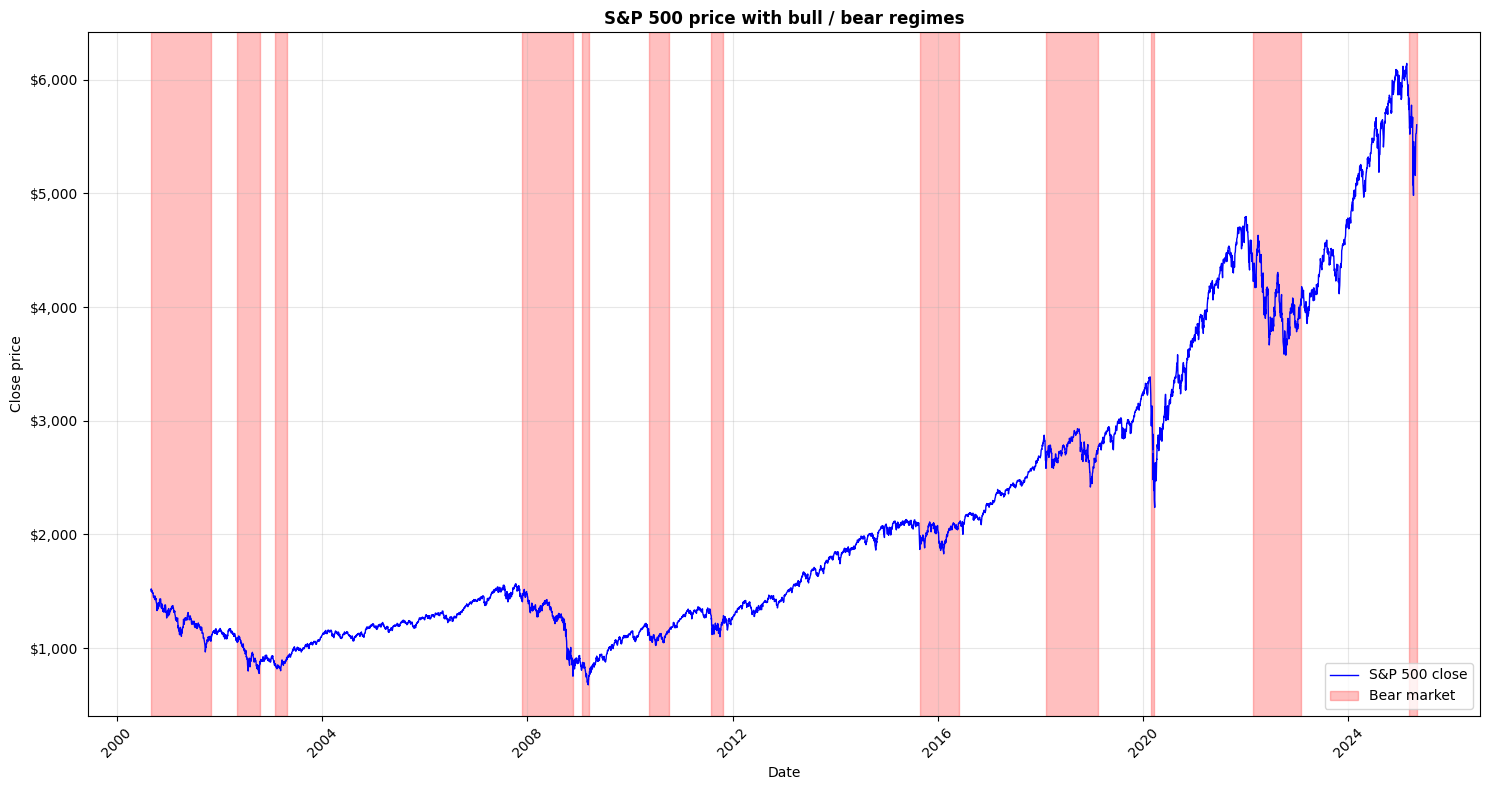


Table 2: Bull and Bear Market Periods
--------------------------------------------------------------------------------------------
Bull markets                                  Bear markets                                  
Dates                           Durat. Amplit.    Dates                           Durat. Amplit.
--------------------------------------------------------------------------------------------
2001-11-05 to 2002-05-03            26       6    2000-08-30 to 2001-11-02            62     -36
2002-10-21 to 2003-01-24            14       4    2002-05-06 to 2002-10-18            24     -28
2003-04-28 to 2007-11-23           239      71    2003-01-27 to 2003-04-25            13      -7
2008-11-24 to 2009-01-16             8      10    2007-11-26 to 2008-11-21            52     -48
2009-03-16 to 2010-05-14            61      61    2009-01-20 to 2009-03-13             8     -20
2010-10-12 to 2011-07-29            42      17    2010-05-17 to 2010-10-08            21     -10
201

In [29]:
plot_sp500_with_regimes_LT(labeled_data)

In [29]:
labeled_data.isna().sum()

SP500_Open           0
SP500_High           0
SP500_Low            0
SP500_Close          0
SP500_Volume         0
VIX                  0
Treasury_10Y         0
Treasury_2Y          0
DXY                  0
WTI_Crude            0
Gold                 0
SP500_Log_Volume     0
SP500_Range          0
SP500_Log_Returns    0
SP500_MA_5           0
SP500_MA_10          0
SP500_SMA_5          0
SP500_SMA_10         0
SP500_RSI            0
SP500_MACD           0
SP500_MACD_Signal    0
SP500_ATR            0
SP500_MTM1           0
SP500_MTM3           0
SP500_WPR            0
SP500_SRA_5          0
SP500_SRA_10         0
Regime_Label         0
dtype: int64

In [32]:
# Count regime labels and calculate percentages
regime_counts = labeled_data['Regime_Label'].value_counts()
regime_percentages = labeled_data['Regime_Label'].value_counts(normalize=True) * 100

# Count regime switches
regime_switches = (labeled_data['Regime_Label'].diff() != 0).sum()

print("Regime Label Distribution:")
print("=" * 40)
print(f"Bear Market (0): {regime_counts[0]:,} observations ({regime_percentages[0]:.1f}%)")
print(f"Bull Market (1): {regime_counts[1]:,} observations ({regime_percentages[1]:.1f}%)")
print(f"Total observations: {len(labeled_data):,}")
print(f"Regime switches: {regime_switches:,}")

Regime Label Distribution:
Bear Market (0): 1,654 observations (27.0%)
Bull Market (1): 4,478 observations (73.0%)
Total observations: 6,132
Regime switches: 23


In [ ]:
labeled_data.to_csv(os.path.join(DATA_DIR, 'labeled_data_cleaned.csv'))


CORRELATION ANALYSIS


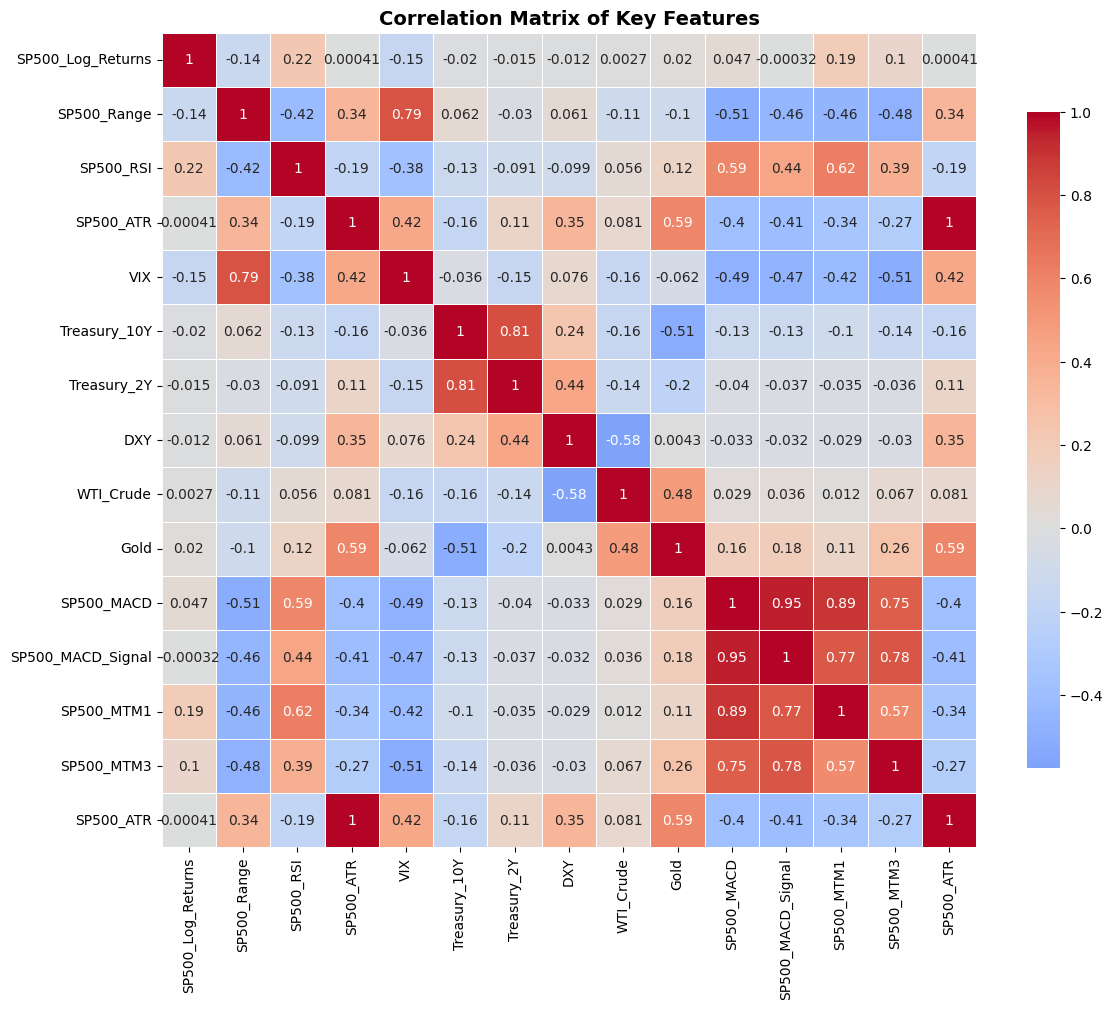

Correlation analysis completed for 15 features


In [38]:
# correlation heatmap of key features
print("\n" + "="*60)
print("CORRELATION ANALYSIS")
print("="*60)

# Select key features for correlation analysis
key_features = [
    'SP500_Log_Returns', 'SP500_Gap_Return', 'SP500_Range', 'SP500_RSI', 
    'SP500_ATR', 'VIX', 'Treasury_10Y', 'Treasury_2Y', 'DXY', 'WTI_Crude', 'Gold', 'SP500_MACD',
    'SP500_MACD_Signal', 'SP500_MTM1', 'SP500_MTM3', 'SP500_ATR'
]

available_key_features = [f for f in key_features if f in full_data_clean.columns]

if len(available_key_features) > 1:
    plt.figure(figsize=(12, 10))
    correlation_matrix = full_data_clean[available_key_features].corr()
    
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix of Key Features', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"Correlation analysis completed for {len(available_key_features)} features")
else:
    print("Insufficient features for correlation analysis")